# SMS Spam Model

## Loading libraries

In [63]:
import pandas as pd
import tensorflow as tf
import numpy as np

## Importing and cleaning data

In [64]:
df = pd.read_csv('data/spam.csv')

In [65]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [66]:
df.rename({'v1': 'CLASS', 'v2': 'CONTENT'}, axis=1, inplace=True)

In [67]:
df['CLASS'] = df['CLASS'].replace({'ham': 0, 'spam': 1})

In [68]:
df.head()

,CLASS,CONTENT
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Preprocessing data

In [69]:
from tensorflow.keras.layers import TextVectorization

In [70]:
X = df['CONTENT']

In [71]:
y = df['CLASS']

In [72]:
MAX_WORDS = 200000 # number of words in the vocab

In [73]:
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                              output_sequence_length=1800,
                              output_mode='int') # mapping words as integers

In [74]:
vectorizer.adapt(X.values) # learning all the words in the vocab

In [75]:
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'to',
 'i',
 'you',
 'a',
 'the',
 'u',
 'and',
 'is',
 'in',
 'me',
 'my',
 'for',
 'your',
 'of',
 'it',
 'call',
 'have',
 'on']

In [76]:
# testing the vectorizer
vectorizer('Hello, my name is Francesco')[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([255,  12, 261,   9,   1])>

In [77]:
vectorized_text = vectorizer(X.values)

In [78]:
# Tensorflow Data Pipeline, MCSHBAP
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [79]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) 
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Creating Sequential Model

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [81]:
model = Sequential()

# Embedding Layer
model.add(Embedding(MAX_WORDS+1,32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final Layer
model.add(Dense(1, activation='sigmoid'))

In [82]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

In [84]:
# Training!
history = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
244/244 [==============================] - 162s 656ms/step - loss: 0.1684 - val_loss: 0.0517
Epoch 2/3
244/244 [==============================] - 180s 739ms/step - loss: 0.0381 - val_loss: 0.0343
Epoch 3/3
244/244 [==============================] - 185s 759ms/step - loss: 0.0167 - val_loss: 0.0053


<Figure size 576x360 with 0 Axes>

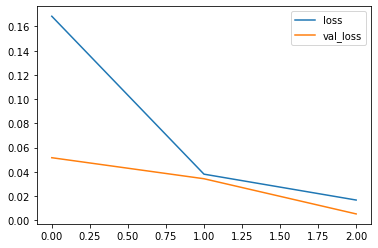

In [85]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Making predictions

In [86]:
input_text = vectorizer('Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.') #Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.

In [87]:
batch = test.as_numpy_iterator().next()

In [88]:
res = model.predict(np.expand_dims(input_text, 0))

In [89]:
res 

array([[0.99460745]], dtype=float32)

In [ ]:
# Seems OK! Let's evaluate the model!

## Evaluating Model

In [90]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [91]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [92]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [93]:
# Printing results
print('Precision: {}, Recall {}, Accuracy: {}' .format(pre.result().numpy(), re.result().numpy(), acc.result().numpy()))

Precision: 1.0, Recall 0.9855072498321533, Accuracy: 0.5588235259056091


## Gradio App

In [94]:
# Example of a Gradio App, you can run it!
import gradio as gr

In [95]:
model.save('spam.h5')

In [96]:
model = tf.keras.models.load_model('spam.h5')

In [97]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    info = ''

    if(results[0] < 0.0025):
        info = 'Not spam'
    else:
        info = 'Spam'

    return info

In [ ]:
interface = gr.Interface(fn=score_comment,
                        inputs = gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs = 'text')

In [ ]:
interface.launch(share=True)